In [1]:
import os

In [2]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import numpy as np
from __future__ import division
import time 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
%load_ext autoreload                                                                                                                                                                                            
%autoreload 

In [3]:
import computational_OT

In [4]:
"""To compute distance matrix"""
def distmat(x,y):
    return jnp.sum( x**2,0 )[:,None] + jnp.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)
"""To Normalise a vector"""
normalize = lambda a: a/jnp.sum( a )
"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]
def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [5]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    key = jax.random.PRNGKey(0)
    key1, key2 = jax.random.split(key)
    x = jax.random.uniform(key = key1, shape = (2,N[0]) )-0.5
    theta = 2*jnp.pi*jax.random.uniform(key = key2, shape =  (1,N[1]) )
    r = 0.8+.2*jax.random.uniform(key = key2, shape =  (1,N[1]) )
    y = jnp.vstack( ( r*jnp.cos( theta ),r*jnp.sin( theta ) ) )
    return x,y

In [6]:
N = [ 500,  600 ]
x , y = generate_data(N)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
rho = 0.95
c = 0.1
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []
#Cost matrix
C = distmat(x,y)
# a and b
a = normalize(jnp.ones(shape =(N[0],1)))
b = normalize(jnp.ones(shape =(N[1],1)))
epsilons = [  0.5, 0.03 ]
for eps in epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    #Kernel
    K = jnp.exp(-C/eps)
    f = 0*a
    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating" )  
    start = time.time()
    out = computational_OT.Damped_Newton_SemiDual_JAX._update(K,a,b,f,eps,rho,c, maxiter = 50 , debug = True)
    results_DampedNewton.append(out)
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")
        
    DampedNewtonP.append(GetP(jnp.exp(out['potential_f']/eps),K,jnp.exp(out['potential_g']/eps)))
    print( " |- Recording (unstabilized) Hessian \n")
    mat  = -eps*out['Hessian']
    diag = 1/jnp.sqrt( jnp.vstack( a ) ).flatten()
    mat = diag*mat*diag
    Hessians_DampedNewton.append( mat )

Damped Newton for epsilon=0.5:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  5
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.03:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  34
 |- Computing P
 |- Recording (unstabilized) Hessian 



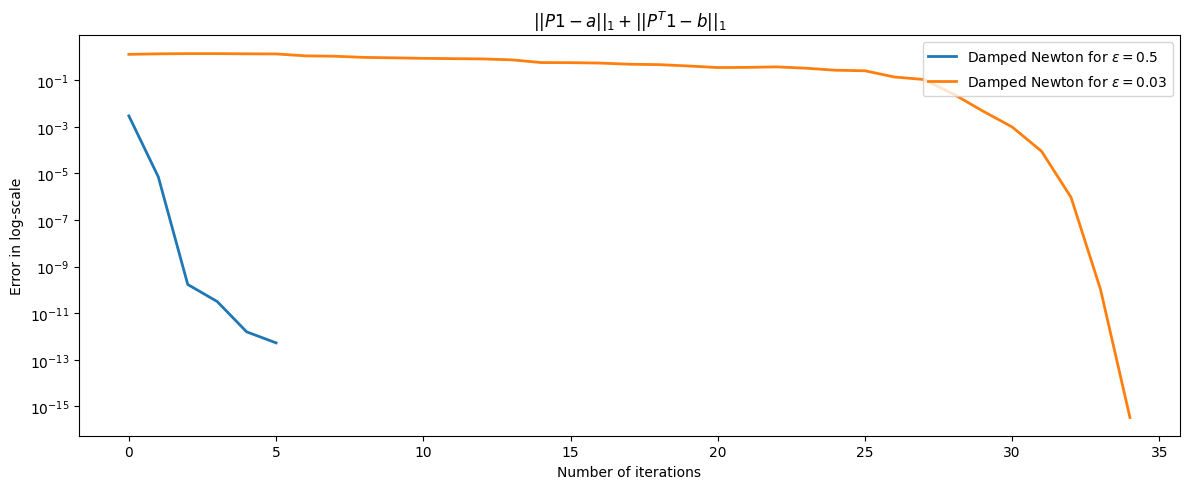


 Error plots can increase! The error is not the objective function!


In [8]:
plt.figure(figsize = (12,5))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")
for i in range(len(results_DampedNewton)):
  error = jnp.asarray(results_DampedNewton[i]['error'])
  plt.plot( error, label = 'Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend(loc = "upper right")
plt.yscale( 'log' )
plt.tight_layout()
plt.savefig("DampedNewton_SemiDual_images/ErrorLinesearchNewton.pdf", format = 'pdf')
plt.show()
print("\n Error plots can increase! The error is not the objective function!")

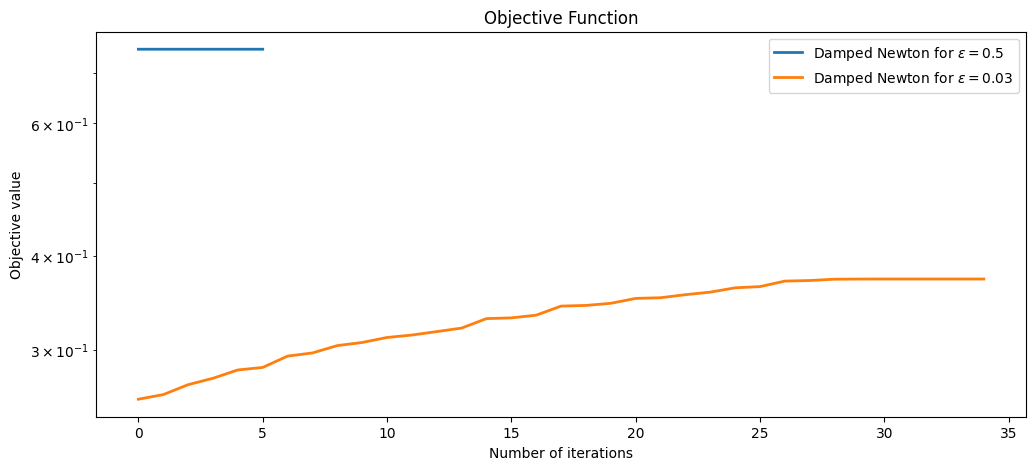

In [9]:
plt.figure(figsize = (12,5))
plt.title("$$")
plt.title("Objective Function")
for i in range(len(results_DampedNewton)):
  value = jnp.asarray(results_DampedNewton[i]['objectives'])
  plt.plot( value,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Objective value")
plt.yscale('log')
plt.legend()
plt.savefig("DampedNewtonTesting_images/ObjectiveLineSearchNewton.pdf", format = 'pdf')
plt.show()

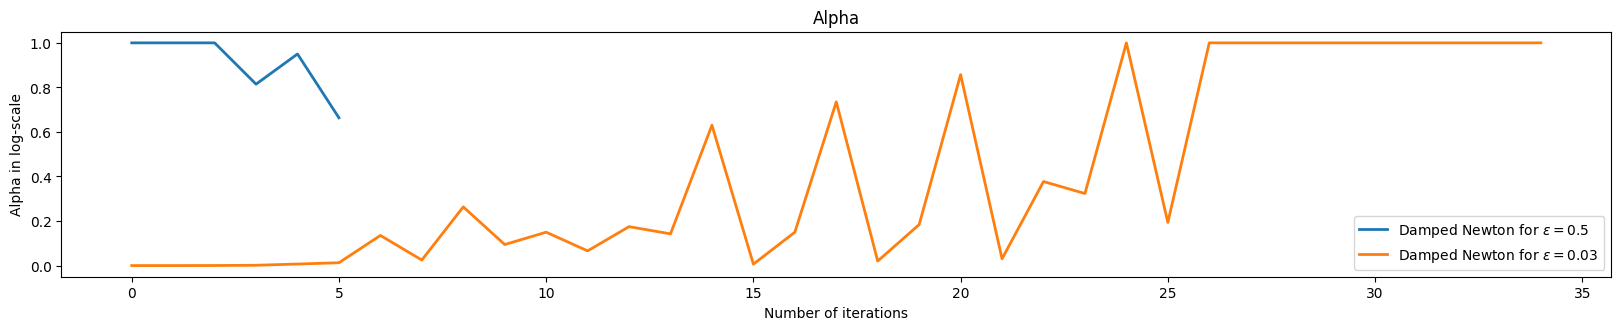

In [10]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")
for i in range(len(results_DampedNewton)):
  plt.plot( jnp.asarray(results_DampedNewton[i]["linesearch_steps"]),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewton_SemiDual_images/AlphaLineSearchNewton.pdf", format = 'pdf')
plt.show()

In [11]:
def print_spectral_statistics(mat, stabilize=False):
    if stabilize:
        # Stabilizing largest and smallest eigenvalue
        min_vector = jnp.hstack( (jnp.ones((N[0],1))) )
        max_vector = jnp.hstack( (jnp.ones((N[0],1))) )
        norm = jnp.sqrt( N[0] )
        min_vector = min_vector/norm
        max_vector = max_vector/norm
        min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
        max_vector = max_vector.reshape( (max_vector.shape[0], 1) )
        #
        mat = mat + jnp.dot( min_vector, min_vector.T)
        mat = mat - jnp.dot( max_vector, max_vector.T)
    # endif
    eig, v = jnp.linalg.eigh( mat )
    sorting_indices = jnp.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    #print( "Mean eigenvalue: ", np.mean(eig) )
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])
    min_index = jnp.argmin(eig)
    max_index = jnp.argmax(eig)
    min_value = eig[min_index]
    max_value = eig[max_index]
    min_vector = v[:, min_index]
    min_vector = min_vector/min_vector[0]
    max_vector = v[:,max_index]
    max_vector = max_vector/max_vector[0]
    condition_number = max_value/min_value
    # Test smallest and largest
    # print( "Min eigenvalue vector: ", min_vector)
    # print( "Max eigenvalue vector: ", max_vector)
    #
    #print( v[:,0]*np.sqrt( self.N1 + self.N2))
    #vector = v[:,0]
    #test = np.dot( result, vector)
    #print( np.linalg.norm(test) )
    #print("Min absolute eigenvalues: ", min_value)
    #print("Norm of v-1: ", np.linalg.norm(min_vector-eig_vector))
    print("Condition number: ", condition_number)
    # plt.hist( eig, 50)
    # plt.title( "Histogram of eigenvalues for Hessian")
    # plt.xlabel( "Eigenvalues")
    # plt.yscale( "log" )
    # plt.show()
    return eig,v

In [12]:
eigs=[]
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = Hessians_DampedNewton[i]
    ev=print_spectral_statistics( Hessian, stabilize=False)
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [0.6748877  0.70826661 0.94919668 0.96948643 0.99659072 0.99673918
 0.99725486 0.9997654  0.99984639 0.99992696]
List of largest  eigenvalues:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Condition number:  1.481728003579264

Spectral statistics of Hessian for epsilon=0.03
List of smallest eigenvalues:  [0.05454187 0.0570965  0.16920399 0.21340351 0.35234748 0.36702577
 0.51250162 0.55861077 0.67662922 0.67993624]
List of largest  eigenvalues:  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.00000002]
Condition number:  18.33453939829791



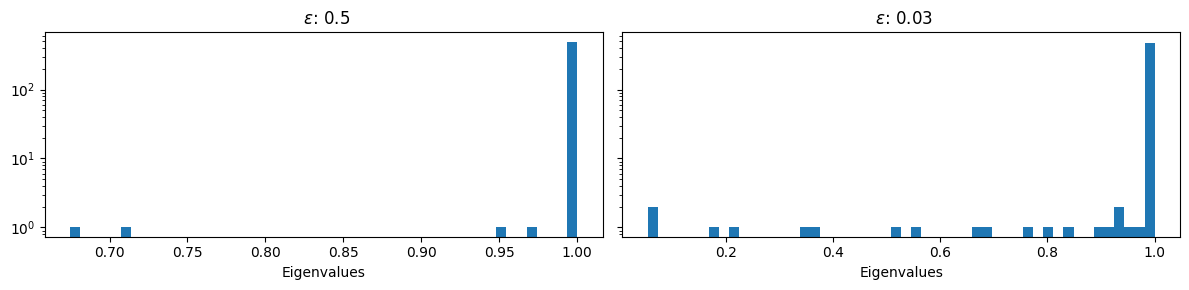

In [13]:
fig,ax=plt.subplots(figsize=(12,3),nrows=1, ncols=len(epsilons), sharey=True)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    ax[i].set_yscale( "log" )
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig("DampedNewton_SemiDual_images/eigenhistunstabilized.pdf", format = 'pdf')
plt.show()

In [14]:
def build_preconditioners( num_eigs,modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = jnp.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = jnp.hstack( (np.ones(N[0])) )
        norm = jnp.sqrt( N[0])
        null_vector = null_vector/norm
    # Form other vectors
    indices = []
    for i in range(num_eigs):
        indices.append(i+1)
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [15]:
num_eigs = 25
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1], ansatz=False )

In [17]:
rho = 0.95
c = 0.1
reset_starting_point    = True
final_modified_Hessians = []
DampedNewtonP           = []
results_DampedNewton    = []
times_DampedNewton      = []
precond_epsilons = [ 0.5 ]
f, g = None, None
# Cost matrix
C = distmat(x,y)
# a and b
a = normalize(jnp.ones(shape =(N[0],1)))    
b = normalize(jnp.ones(shape =(N[1],1)))
for eps in precond_epsilons:
    #Kernel
    K = jnp.exp(-C/eps)
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    if (f is None) or (g is None): 
        f, g = a*0, b*0 
    print( "Doing for (",N[0],N[1],").")
    print( " |- Iterating" )  
    start = time.time() 
    out = computational_OT.Damped_Newton_precond_SemiDual_JAX._update( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:], maxiter = 50, iterative_inversion = 30, 
                                                                      version = 3, debug = False, optType = 'cg')
    results_DampedNewton.append( out ) 
    end = time.time()   
    times_DampedNewton.append(1e3*(end-start))
    print( " |- Computing P" )
    if not reset_starting_point:
        f = out.x[:a.shape[0]]
        g = out.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    DampedNewtonP.append( GetP(jnp.exp(out['potential_f']/eps),K,jnp.exp(out['potential_g']/eps)) )
    #final_modified_Hessians.append( Optimizer.modified_Hessian )

Damped Newton for epsilon=0.5:
Doing for ( 500 600 ).
 |- Iterating

 At iteration:  0

|--- Time required for initial preconditioning:  7.624630000000001 ms---|
|--- Time required for preconditioning matrix formation:  55.63045 ms---|


|--- Time required for changing A to PAP:  449.97048 ms---|
...
  --- CG exit code:  None
|--- Time taken to invert the linear system for p_k:  359.49159000000003 ms---|
|--- Time taken for unwinding:  0.96869 ms---|
|--- Time taken for the complete code block:  875.57 ms---|


 At iteration:  1

|--- Time required for initial preconditioning:  6.56557 ms---|
|--- Time required for preconditioning matrix formation:  13.207440000000002 ms---|
|--- Time required for changing A to PAP:  14.765740000000001 ms---|
...
  --- CG exit code:  None
|--- Time taken to invert the linear system for p_k:  307.03402 ms---|
|--- Time taken for unwinding:  0.8890600000000001 ms---|
|--- Time taken for the complete code block:  344.05 ms---|


 At iteration:  2

|--- Time required for initial preconditioning:  7.4756100000000005 ms---|
|--- Time required for preconditioning matrix formation:  24.028060000000004 ms---|
|--- Time required for changing A to PAP:  12.641190000000002 ms---|
...
  --- CG exit

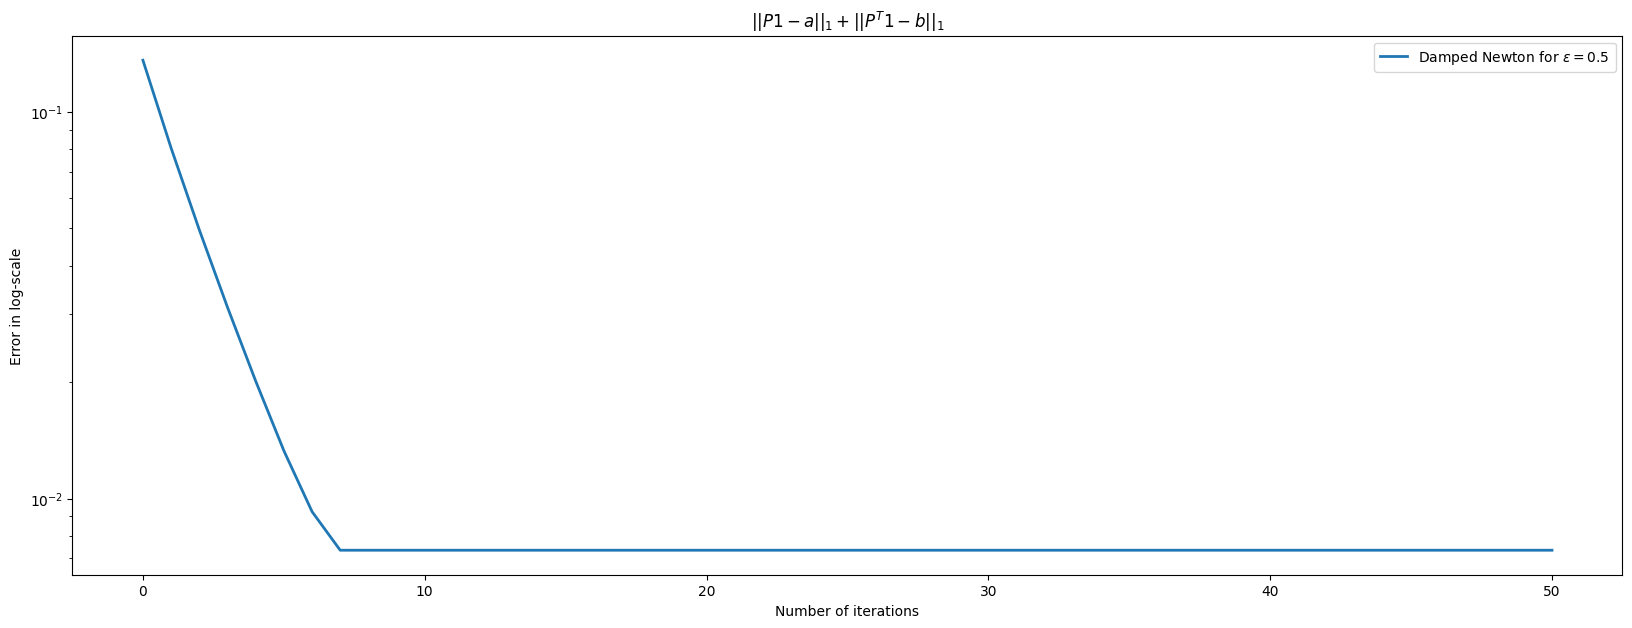


 Error plots can increase! The error is not the objective function!


In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T1 -b||_1$")
for i in range(len(results_DampedNewton)):
  error = np.asarray(results_DampedNewton[i]['error'])
  plt.plot( error, label = 'Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale('log')
plt.savefig("DampedNewton_SemiDual_images/ErrorDampedNewtonwithPrecond_final_cg.png")
plt.show()
print("\n Error plots can increase! The error is not the objective function!")

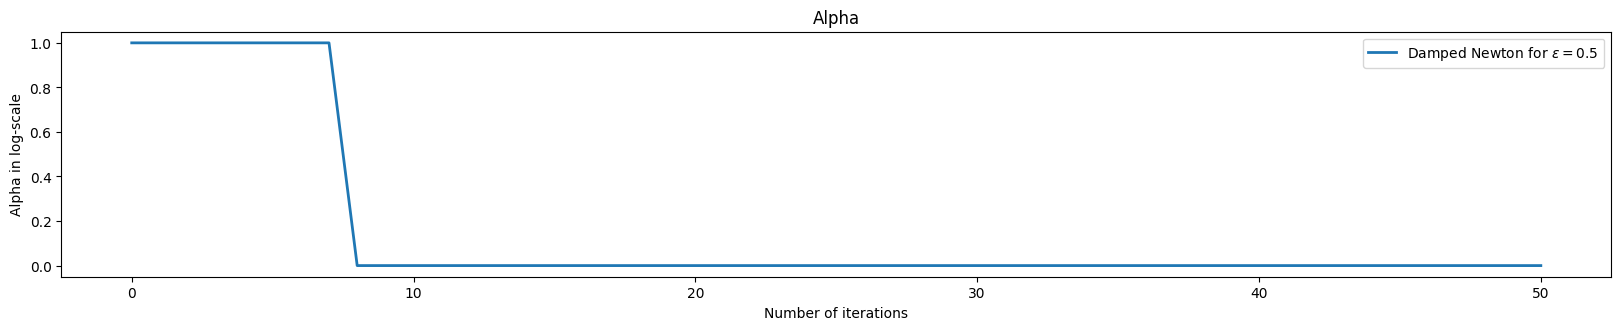

In [ ]:
plt.figure(figsize = (20,7))  
plt.subplot(2,1,1),
plt.title("Alpha")
for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i]["linesearch_steps"]),label = 'Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.show()